In [221]:
#make a shelter density map given a csv file

In [235]:
#importing required libraries

import os

import pandas as pd
import numpy as np

import mpl_toolkits
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


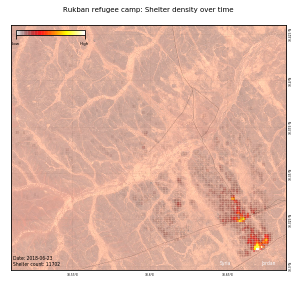

In [234]:
#input parameters

#path setting
data_path = '../data/csv/Rukban_Structures_20180623.csv'
roadlines_path = '../data/hotosm_syr_roads_lines_shp/hotosm_syr_roads_lines'

camp_boundary = [38.5100, 38.6877, 33.2980, 33.43] #manually set

#map resultion
ro = 0.001

#map dpi value
dpi_val = 400

#common parameters parameters
proj = 'merc'     #map projection.

#parallels & meridians
parallels = np.arange(0.,81,0.025)
meridians = np.arange(10.,351.,0.05)

#load city data
data_df = pd.read_csv(data_path)

#extract coordinates of damage structures
coors = data_df[['X', 'Y']]

#extract analysis date
analysis_date = os.path.basename(data_path).split('_')[2][0:8]
analysis_date = analysis_date[0:4] + '-' + analysis_date[4:6] + '-' + analysis_date[6:8]


Xmin = camp_boundary[0]
Xmax = camp_boundary[1]
Ymin = camp_boundary[2]
Ymax = camp_boundary[3]

Xmid = (Xmax - Xmin)/2.0
Ymid = (Ymax - Ymin)/2.0

nx = np.round((Xmax - Xmin)/ro).astype(int)
ny = np.round((Ymax - Ymin)/ro).astype(int)

params = {
    'lat_m'    : Ymid,  #latituded of map's center.
    'lon_m'    : Xmid,  #longitude of map's center.
    'lon_bins' : np.linspace(Xmin, Xmax, nx), #generate longitude bins.
    'lat_bins' : np.linspace(Ymin, Ymax, ny) #generate latitude bins.
}


canvas = {
    'bins_2d'       : np.meshgrid(params['lon_bins'], params['lat_bins']), #make mesh grid
    'freq_late_lone': np.histogram2d(coors['Y'], coors['X'], [params['lat_bins'], params['lon_bins']]),
    'map'           : Basemap(
                    projection= proj, resolution = 'l', 
                    llcrnrlon= Xmin, llcrnrlat= Ymin,
                    urcrnrlon= Xmax, urcrnrlat= Ymax
)
}

#convert bin mesh to map coordinates
xs, ys = canvas['map'](canvas['bins_2d'][0], canvas['bins_2d'][1])


#color map
cmap = plt.cm.hot
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N) #transparency
my_cmap = ListedColormap(my_cmap)



fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)

plt.title('Rukban refugee camp: Shelter density over time\n', fontsize=7)

canvas['map'].readshapefile(roadlines_path, 'tmp', drawbounds = True, linewidth=0.1) #shaepfile
canvas['map'].imshow(plt.imread('../data/raster/2016-06-24/clip.jpg'), origin='upper', alpha=0.7) #map image background
canvas['map'].drawparallels(parallels,labels=[False,True,True,False], linewidth=0.05, fontsize=3, rotation='vertical')
canvas['map'].drawmeridians(meridians,labels=[True,False,False,True], linewidth=0.05, fontsize=3)

plt.pcolormesh(xs, ys, canvas['freq_late_lone'][0], cmap=my_cmap, shading='flat')


#add color key (index) & a label
cbaxes = inset_axes(ax, width="25%", height="2%", loc=2) 
cbar = plt.colorbar(cax=cbaxes, ticks=[canvas['freq_late_lone'][0].min(), canvas['freq_late_lone'][0].max()], orientation='horizontal')

cbar.ax.set_xticklabels(['Low', 'High'], fontsize=4)


#annotate map
ax.annotate('Date: {0}'.format(analysis_date), xy=(200, 750), fontsize=4.5)
ax.annotate('Shelter count: {0}'.format(len(coors)), xy=(200, 300), fontsize=4.5)
ax.annotate('Jordan', xy=(18000, 400), fontsize=4.5, color='white')
ax.annotate('Syria', xy=(15000, 400), fontsize=4.5, color='white')


#output path
out_fig_path = '../data/dense_map/figure2_{}.png'.format(analysis_date)

#save figure
fig.tight_layout()
plt.savefig(out_fig_path, dpi=dpi_val, bbox_inches='tight') #save map to a .png file (comment if not needed).